# MF-DFA Code Test on Fractional Gaussian Noise

The FBM libray for Python allows for easy generation of FBM time series. We can use our MF-DFA code to analyze this signal and make sure that the MF-DFA code is reading the right values. 

First let's import all the necessary libraries and functions (including the MF-DFA functions):

* To run this code the following libraries are required: matplotlib, numpy, MFDFA, fbm

All of these can be installed using pip install package_name

In [1]:
from fbm import FBM
import matplotlib.pyplot as plt
import sys
from MFDFA import MFDFA
import MFDFAlib
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

First, we need to generate the noise. With the fbm package we can create a function that allows for the Hurst parameter for the noise to be set. It outputs a signal function, f(t) that is the noise generated for the input sample number, Hurst parameter, and time length. This is primarily what we will use to test the MF-DFA functions.

In [2]:
""" In this function we are taking in the following information, set by the user:
num_samples | this is the number of points returned in the generated time series.
hurst_par | this is the hurst parameter for the time series
time_length | this is the length of time that the time series spans


We return a series of """
def fbmGenerate(num_samples, hurst_par, time_length):
    f = FBM(n=num_samples, hurst=hurst_par, length=time_length, method='daviesharte')

    # Generate a fBm realization (fractional Brownian motion)
    fbm_sample = f.fbm()

    # Generate a fGn realization (fractional Gaussian noise)
    fgn_sample = f.fgn()

    # Get the times associated with the fBm
    t_values = f.times()

    #plot the noise signal:
    plt.plot(t_values[1:],fgn_sample)
    plt.xlabel('Time, t (s)')
    plt.ylabel('Noise Signal, f(t) (Dimensionless)')
    plt.show()

    return np.array(t_values), np.array(fgn_sample) 


Now we need to load our necessary MF-DFA functions:

In [3]:
### SET THE HURST PARAMETER HERE ###

#Let's try N=10^6 samples, 0.70 Hurst parameter, and 1s time length:
hurstParam = 0.70
timeLength = 1
numSamples = 10**6

#####################################

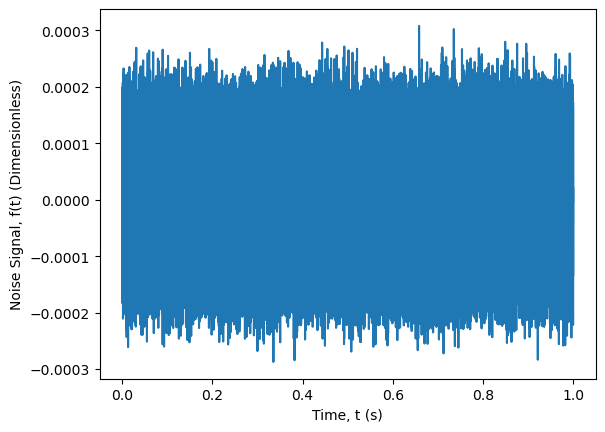

In [7]:

# Generate the FGN : 
timeSeries = fbmGenerate(numSamples, hurstParam, timeLength)

# Extract the times and signal from the fbmGenerate function:
times=timeSeries[0]
signal=timeSeries[1]

# Here we choose the set of lags:
lag = np.arange(10,1000,1)

# We also need to choose a range of q-values. -20 to 20 is what Gomes et al. use for MMS1 data.
# -20 to 20 also provides a good amount of negative and positive points to get a sense of what 
# is going on.
qList=np.arange(-2,2,0.25).tolist()
qList.remove(0)

# In order to find the fluctuation function, we need to choose an order of polynomial fitting.
# Gomes et al. choose order=3.
order=2

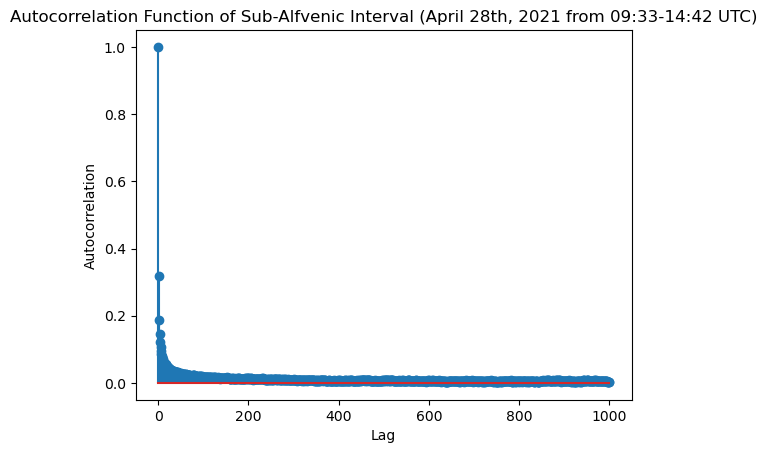

In [8]:
# Calculate the autocorrelation function using statsmodels library
acf = sm.tsa.acf(signal, nlags = 1000)
plt.stem(range(len(acf)), acf)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function of Sub-Alfvenic Interval (April 28th, 2021 from 09:33-14:42 UTC)")
plt.show()


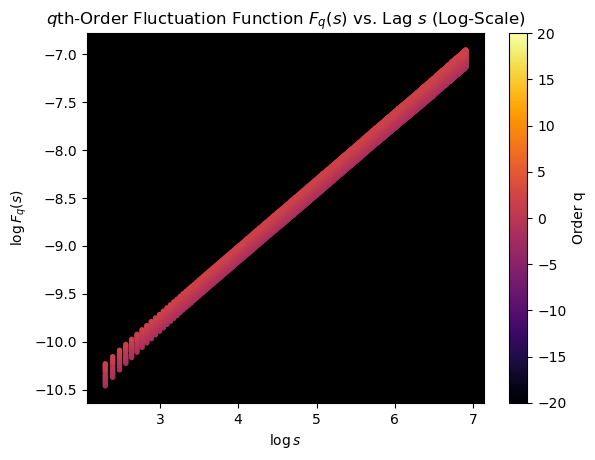

In [9]:
# Find the fluctuation function:
lag, dfaList = MFDFAlib.flucFunc(signal,lag, qList, order)

[0.7020612379629757, 0.7020227878617963, 0.7020039207789676, 0.7020038866852242, 0.7020219693057586, 0.7020574897508807, 0.7021098089909446, 0.7021783290552193, 0.7023617828063679, 0.7024757177245506, 0.702603849047945, 0.7027457555935834, 0.7029010376160436, 0.7030693102077422, 0.703250196312028]


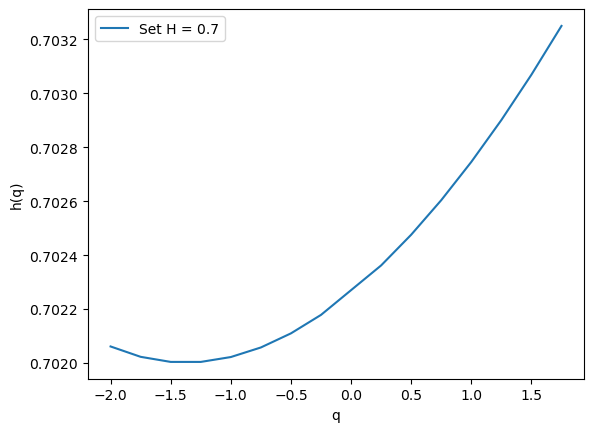

In [11]:
# Here I am sending the dfaList and converting it to a list of Hurst parameters for each q.
# I use the transpose of dfaList for the purpose of easily parsing each row of the matrix
hList=MFDFAlib.hList(lag,dfaList.T)
print(hList)
# Plot h(q):
plt.plot(qList,hList)
plt.xlabel('q')
plt.ylabel('h(q)')
plt.legend([f'Set H = {hurstParam}'])
plt.show()

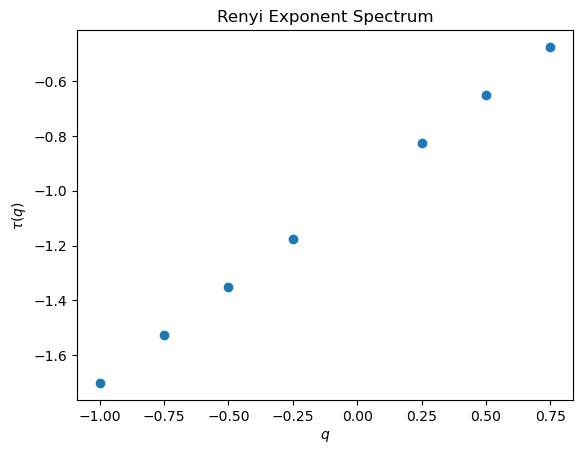

In [14]:
# Now find and plot the Renyi exponent spectrum from the Hurst spectrum:
tauFunc=MFDFAlib.renyiExp(qList,hList)
########PLOTTING#################
plt.plot(qList,tauFunc,'o')
plt.xlabel(r'$q$')
plt.ylabel(r'$\tau(q)$')
plt.title('Renyi Exponent Spectrum')
plt.show()
#################################

04-Apr-25 12:01:43: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


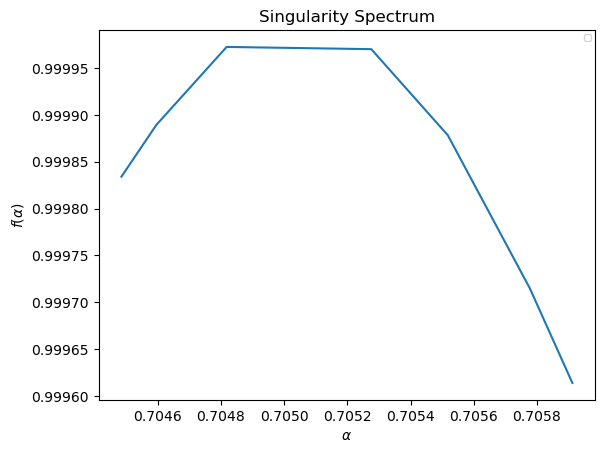

In [9]:
# Finally, from the Renyi exponents, find and plot the multifractal spectra:
alphaList, mfList = MFDFAlib.mfSpec(tauFunc, qList)
#######PLOTTING##################
# Finally, plot the f(alpha) function
plt.plot(alphaList, mfList)
plt.title('Singularity Spectrum')
plt.legend(fontsize = "xx-small")
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$f(\alpha)$')
plt.show()
#################################

## Conclusion:
The MF-DFA library seems to return roughly the correct Hurst parameter, depending on the q value scaling. This indicates that it should be returning the correct values with the MMS1 data.  